# Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
import random

torch.manual_seed(0)
random.seed(0)

In [2]:
Dens_data = np.load(r"../Databases/Database['Specific_density'] With PubChem - Updated 20230719-172934.pkl",allow_pickle = True) # Density data
Visc_data = np.load(r"../Databases/Database['Viscosity'] With PubChem - Updated 20230720-163216.pkl",allow_pickle = True) # Viscosoty data
Cond_data = np.load(r"../Databases/Database['Electrical_conductivity'] With PubChem - Updated 20230720-222648.pkl",allow_pickle = True) # Electrical Conductivity data
Heat_data = np.load(r"../Databases/Database['Heat_capacity_at_constant_pressure'] With PubChem - Updated 20230719-150517.pkl",allow_pickle = True) # Heat Capacity data
Melt_data = np.load(r"../Databases/Database['Normal_melting_temperature'] With PubChem - Updated 20230718-125617.pkl",allow_pickle = True) # Melting Temperature data
Visc_Dens_Cond_data = np.load(r"../Databases/Database['Electrical_conductivity', 'Viscosity', 'Specific_density'] With PubChem - Updated 20230720-141035.pkl",allow_pickle = True) # Data with density, viscosity, and molar conductivity from the same study
Ea_data = pd.read_csv(r"../Databases/Ea_Data.csv") # Activation energies and pre-exponential factors from data fit using the modified Arrhenius equation

Data = Visc_Dens_Cond_data[['compString',
    'numAtomsCation',
    'numAtomsAnion',
    'SimVolume_cation',
    'SimVolume_anion',
    'Sim_rCation',
    'Sim_rAnion',
    'Sim_vCation/vAnion',
    'polarArea_Cation',
    'polarArea_Anion',
    'polarArea_IonPair',
    'rotatableBondCount_Cation',
    'rotatableBondCount_Anion',
    'rotatableBondCountFraction_Anion',
    'rotatableBondCountFraction_Cation',
    'hBondAcceptorCount_Anion',
    'hBondAcceptorCount_Cation',
    'hBondDonorCount_Anion',
    'hBondDonorCount_Cation',
    'hBond_anionDonorInteraction',
    'hBond_cationDonorInteraction',
    'mmCation',
    'mmAnion',
    'Temperature',
    'SimLogP_anion',
    'SimLogP_cation',
    'totalBondCount_Anion',
    'totalBondCount_Cation',
    'Asphericity_cation', #rdkitparams, averages of 50 conformers by default
    'Spherocity_cation',
    'Asphericity_anion',
    'Spherocity_anion',
    'Valence_Electrons_cation',
    'Valence_Electrons_anion',
    'MinPartialCharge_anion',
    'MinPartialCharge_cation',
    'MaxPartialCharge_cation',
    'MaxPartialCharge_anion',
    'Asphericity_cation_std%',  # these are standard deviations from 50 conformers (50 is default, make sure that's not changed)
    'Spherocity_cation_std%',
    'Asphericity_anion_std%',
    'Spherocity_anion_std%',
    'SimNernstEinstein_Scm2_mol',
    'Electrical_conductivity',
    'molarCond_Scm2mol',
    'Viscosity',
    'Specific_density',
    'Smiles_anion',
    'Smiles_cation',
    'Mols_cation',
    'Mols_anion',
    'chargeCation',
    'chargeAnion'
    ]]

Na = 6.022E23
e = 1.60217662E-19

Data.loc[Data['chargeCation'] == 0, 'SimNernstEinstein_Scm2_mol'] = Na*(e**2)/6/np.pi/Data.loc[Data['chargeCation'] == 0, 'Viscosity']*(1/Data.loc[Data['chargeCation'] == 0, 'Sim_rCation']+1/Data.loc[Data['chargeCation'] == 0, 'Sim_rAnion'])*100*100 # Correcting Nernst-Predictions of 0
Data.loc[Data['chargeAnion'] == 0, 'SimNernstEinstein_Scm2_mol'] = Na*(e**2)/6/np.pi/Data.loc[Data['chargeAnion'] == 0, 'Viscosity']*(1/Data.loc[Data['chargeAnion'] == 0, 'Sim_rCation']+1/Data.loc[Data['chargeAnion'] == 0, 'Sim_rAnion'])*100*100 # Correcting Nernst-Predictions of 0

Data = Data.drop(['chargeAnion', 'chargeCation'], axis=1) # Dropping constants

Data['NE Ratio'] = np.divide(Data['molarCond_Scm2mol'], Data['SimNernstEinstein_Scm2_mol']) # Calculating ratio of measured conductivity over Nernst-Einstein predictions

Data['Residual Conductivity'] = (Data['molarCond_Scm2mol'] - Data['SimNernstEinstein_Scm2_mol']) # Calculating difference between conductivity and Nernst-Einstein predictions

/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Choose Properties and Parameters

In [3]:
# Select Property of Interest

# Property, Prop_name, Units = "Residual Conductivity", "Residual Conductivity", '($\mathregular{S \cdot cm^{2} \cdot Mol^{-1}}$)'
# Property, Prop_name, Units = "NE Ratio", "Nernst-Einstein Ratio", ''
# Property, Prop_name, Units = "Viscosity", "Viscosity", '($\mathregular{Pa \cdot s}$)'
Property, Prop_name, Units = "molarCond_Scm2mol", "Molar Conductivity", '($\mathregular{S \cdot cm^{2} \cdot Mol^{-1}}$)'
# Property, Prop_name, Units = "Specific_density", "Density", '($\mathregular{Kg \cdot m^{-3}}$)'
# Property, Prop_name, Units = "Electrical_conductivity", "Specific Conductivity", '($\mathregular{S \cdot m^{-1}}$)'
# Property, Prop_name, Units = "Heat_capacity_at_constant_pressure", "Heat Capacity", '($\mathregular{J \cdot mol^{-1} \cdot K^{-1})}$)'
# Property, Prop_name, Units = "Normal_melting_temperature", "Melting Temperature", '($\mathregular{ K }$)'
# Property, Prop_name, Units = "Log A_m", "Log(A)", '($\mathregular{ Log[S \cdot cm^{2} \cdot K \cdot Mol^{-1}]}$)'
# Property, Prop_name, Units = "Ea_m", "Activation Energy", '($\mathregular{kJ \cdot mol^{-1}}$)'


# Select Neural Network Inputs (Change False to True)

RDKit = True
Graph = False
Visc_Cond_Dens = False

In [4]:
if ((Property == "Log A_m") or (Property == "Ea_m")):
    Ea_data = pd.merge(Data, Ea_data[['compString', 'Ea_m', 'A_m']].loc[Ea_data['Ea_m'] > 5].drop_duplicates(subset='compString', keep='first'), how='left',on=['compString']) # Appending Ea and pre-exponential factor
    Ea_data['Log A_m'] = np.log10(Ea_data['A_m']) # Log-scale pre-exponential factor
    Data = Ea_data
    
if (Property == ("Heat_capacity_at_constant_pressure")):
    Heat_capacity_data = Heat_data[['compString', 'Smiles_cation', 'Smiles_anion', 'Heat_capacity_at_constant_pressure', 'Temperature']].sort_values(by=['compString', 'Temperature', 'Heat_capacity_at_constant_pressure']).dropna().drop_duplicates(subset=['compString', 'Temperature'], keep='last') # Dropping duplicate measurements
    Data = pd.merge(Data, Heat_capacity_data, how='inner', on=['compString', 'Temperature', 'Smiles_cation', 'Smiles_anion'])

if (Property == ("Normal_melting_temperature")):
    Melting_temperature_data = Melt_data[['compString', 'Smiles_cation', 'Smiles_anion', 'Normal_melting_temperature']].loc[Melt_data['Smiles_cation'] != ''].sort_values(by=['compString', 'Normal_melting_temperature']).dropna().drop_duplicates(subset=['compString'], keep='last').reset_index(drop=True) # Importing melting temperature data
    Data = pd.merge(Data, Melting_temperature_data, how='inner', on=['compString', 'Smiles_cation', 'Smiles_anion']).drop_duplicates(subset=['compString'], keep='last')
    Data = Data.loc[Data['Normal_melting_temperature'] < 350]
    
Data = Data.dropna().reset_index(drop=True)

Y_data = Data[[Property]]
ID_data = Data[['compString', 'Smiles_anion', 'Smiles_cation', 'SimNernstEinstein_Scm2_mol', 'Mols_cation', 'Mols_anion']]

if RDKit == True:
     X_data = Data.drop(['compString', 'Smiles_anion', 'Smiles_cation', 'SimNernstEinstein_Scm2_mol', 'Electrical_conductivity', 'Mols_cation', 'Mols_anion', 'NE Ratio', 'Residual Conductivity'], axis=1)
     if ((Property == "Log A_m") or (Property == "Ea_m")):
          X_data = X_data.drop(['Ea_m', 'A_m', 'Log A_m'], axis=1)
     if Property == ("Heat_capacity_at_constant_pressure"):
          X_data = X_data.drop(['Heat_capacity_at_constant_pressure'], axis=1)
     if Property == ("Normal_melting_temperature"):
          X_data = X_data.drop(['Normal_melting_temperature'], axis=1)

elif RDKit != True:
     X_data = Data[['Viscosity', 'molarCond_Scm2mol', 'Specific_density']]

if (Visc_Cond_Dens) == True:
     if Property == ("Viscosity"):
          X_data = X_data.drop(['Viscosity'], axis=1)
     if Property == ("molarCond_Scm2mol"):
          X_data = X_data.drop(['molarCond_Scm2mol'], axis=1)
     if Property == ("Specific_density"):
          X_data = X_data.drop(['Specific_density'], axis=1)
     if Property == ("Residual Conductivity"):
          X_data = X_data.drop(['molarCond_Scm2mol'], axis=1)

elif (Visc_Cond_Dens) != True:
     X_data = X_data.drop(['Viscosity', 'molarCond_Scm2mol', 'Specific_density'], axis=1)

Y_Scaler = StandardScaler()
Y_scaled = pd.DataFrame(Y_Scaler.fit_transform(Y_data))

if (RDKit or Visc_Cond_Dens):
    X_Scaler = StandardScaler()
    X_scaled = pd.DataFrame(X_Scaler.fit_transform(X_data))

if Graph:
    Cations = ID_data.Smiles_cation
    Anions = ID_data.Smiles_anion

    Cat_max_size = 0
    An_max_size = 0

    k = 0
    Cation_matrices = np.zeros(Cations.shape[0]).tolist()
    Anion_matrices = np.zeros(Anions.shape[0]).tolist()
    Full_matrices = np.zeros(Anions.shape[0]).tolist()

    for i in Cations.index:
        Cation_matrices[k] = Chem.GetAdjacencyMatrix(ID_data.loc[ID_data['Smiles_cation'] == Cations[i]]['Mols_cation'].reset_index(drop=True)[0])
        Cation_matrices[k] = np.pad(Cation_matrices[k], (0,33-Cation_matrices[k].shape[0]), 'constant', constant_values=(0)).flatten()
        if Cat_max_size < Cation_matrices[k].shape[0]:
            Cat_max_size = Cation_matrices[k].shape[0]

        Anion_matrices[k] = Chem.GetAdjacencyMatrix(ID_data.loc[ID_data['Smiles_anion'] == Anions[i]]['Mols_anion'].reset_index(drop=True)[0])
        Anion_matrices[k] = np.pad(Anion_matrices[k], (0,33-Anion_matrices[k].shape[0]), 'constant', constant_values=(0)).flatten()
        if An_max_size < Anion_matrices[k].shape[0]:
            An_max_size = Anion_matrices[k].shape[0]

        if RDKit == True:
            Full_matrices[k] = np.concatenate((Cation_matrices[k], Anion_matrices[k], X_scaled.to_numpy()[i]))
        if RDKit != True:
            Full_matrices[k] = np.concatenate((Cation_matrices[k], Anion_matrices[k]))

        k += 1

    Temp_scale = StandardScaler()
    X_scaled = pd.concat((pd.DataFrame(Full_matrices), pd.DataFrame(Temp_scale.fit_transform(Data[['Temperature']]))), axis=1)

# Neural Network

In [5]:
k_fold = int(5)

train_indices = [0.0]*k_fold
test_indices = [0.0]*k_fold

Train_Input = [[]]*k_fold
Train_Target = [[]]*k_fold
Test_Input = [[]]*k_fold
Test_Target = [[]]*k_fold

i = 0
gss = GroupKFold(n_splits=k_fold)

for train_idx, test_idx in gss.split(X_scaled, X_scaled, ID_data['compString']):
    train_indices[i] = train_idx
    test_indices[i] = test_idx

    Train_Input[i] = X_scaled.iloc[train_indices[i].tolist(),:].values
    Train_Target[i] = Y_scaled.iloc[train_indices[i].tolist(),:].values

    Test_Input[i] = X_scaled.iloc[test_indices[i].tolist(),:].values
    Test_Target[i] = Y_scaled.iloc[test_indices[i].tolist(),:].values

    i += 1

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class IL_GNN(nn.Module):
    def __init__(self):
        super(IL_GNN, self).__init__()
        self.n_input = Train_Input[0][0].shape[0]
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 64),
            nn.Sigmoid(),
            nn.Dropout(0),
            nn.Linear(64,32),
            nn.Sigmoid(),
            nn.Dropout(0),
            nn.Linear(32,16),
            nn.ReLU(0),
            nn.Linear(16,8),
            nn.ReLU(0),
            nn.Linear(8,1)
        )
    def forward(self,x):
        return self.main(x)
    
def weights_init(m):
    torch.manual_seed(5)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

IL_gnn = IL_GNN().to(device)

In [7]:
criterion = nn.MSELoss()
optim_i = optim.Adam(IL_gnn.parameters(), lr=0.000288)

torch.manual_seed(7777)

Test_check = 10
Print_freq = 100
epochs = 1000 # Adjust epochs to minimize test set error
Training_Losses = np.zeros((k_fold,epochs))
Test_Losses = np.zeros((k_fold,int(epochs/Test_check)))

Train_pred = [0.0]*k_fold
Test_pred = [0.0]*k_fold

batch = 256

for k in range(0,5):
    print('Model '+str(k))
    Train_order = np.arange(0,Train_Input[k].shape[0],batch)
    IL_gnn.apply(weights_init)
    for epoch in range(epochs):
        loss = 0.0
#        np.random.shuffle(Train_order)
        for i in Train_order:
            pred = IL_gnn.forward(torch.Tensor(np.stack(Train_Input[k][i:i+batch])))
            optim_i.zero_grad()
            loss_current = criterion(torch.Tensor(pred), torch.Tensor(np.array(Train_Target[k][i:i+batch])))
            loss_current.backward(retain_graph=True)
            optim_i.step()
            loss += loss_current.item()/(len(Train_order))

        if epoch%Test_check == 0:
            T_pred = IL_gnn.forward(torch.Tensor(np.stack(Test_Input[k]))).detach().numpy()
            Test_loss = mean_squared_error(T_pred, Test_Target[k])
            Test_Losses[k][int(epoch/Test_check)] = Test_loss
            if epoch%Print_freq == 0:
                print('Epoch: ' + str(epoch) + ', Loss: ' + str(np.round(loss, 6)) + ', Test Loss: ' + str(np.round(Test_loss, 6)))            
        
        Training_Losses[k][epoch] = loss

    Train_pred[k] =  IL_gnn.forward(torch.Tensor(np.stack(Train_Input[k]))).detach().numpy()
    Test_pred[k] = IL_gnn.forward(torch.Tensor(np.stack(Test_Input[k]))).detach().numpy()
    
Final_Train_Predictions = Y_Scaler.inverse_transform(np.concatenate((Train_pred[0],Train_pred[1], Train_pred[2], Train_pred[3], Train_pred[4])))
Final_Train_Target = Y_Scaler.inverse_transform(np.concatenate((Train_Target[0],Train_Target[1], Train_Target[2], Train_Target[3], Train_Target[4])))

Final_Test_Predictions = Y_Scaler.inverse_transform(np.concatenate((Test_pred[0],Test_pred[1], Test_pred[2], Test_pred[3], Test_pred[4])))
Final_Test_Target = Y_Scaler.inverse_transform(np.concatenate((Test_Target[0],Test_Target[1], Test_Target[2], Test_Target[3], Test_Target[4])))

Model 0
Epoch: 0, Loss: 1.895535, Test Loss: 2.014271
Epoch: 100, Loss: 0.145508, Test Loss: 0.313383
Epoch: 200, Loss: 0.06699, Test Loss: 0.250241
Epoch: 300, Loss: 0.050509, Test Loss: 0.242847
Epoch: 400, Loss: 0.041208, Test Loss: 0.244956
Epoch: 500, Loss: 0.033843, Test Loss: 0.248991
Epoch: 600, Loss: 0.028746, Test Loss: 0.237281
Epoch: 700, Loss: 0.025003, Test Loss: 0.229375
Epoch: 800, Loss: 0.022479, Test Loss: 0.224697
Epoch: 900, Loss: 0.020224, Test Loss: 0.217811
Model 1
Epoch: 0, Loss: 1.573532, Test Loss: 1.223161
Epoch: 100, Loss: 0.120416, Test Loss: 0.198289
Epoch: 200, Loss: 0.06252, Test Loss: 0.152022
Epoch: 300, Loss: 0.041793, Test Loss: 0.132623
Epoch: 400, Loss: 0.030411, Test Loss: 0.126778
Epoch: 500, Loss: 0.024478, Test Loss: 0.125356
Epoch: 600, Loss: 0.021, Test Loss: 0.124661
Epoch: 700, Loss: 0.018743, Test Loss: 0.12351
Epoch: 800, Loss: 0.017412, Test Loss: 0.122807
Epoch: 900, Loss: 0.016387, Test Loss: 0.124397
Model 2
Epoch: 0, Loss: 1.236993, 

# Plotting

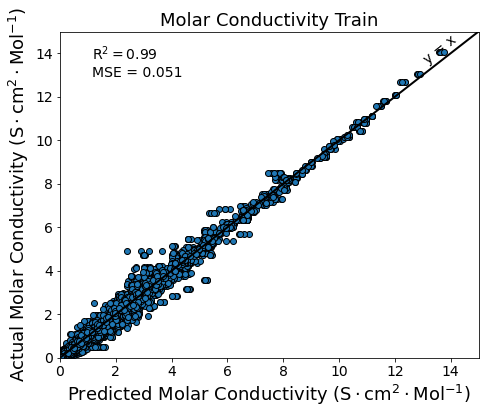

In [8]:
fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='white')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

ax1.set_xlim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))
ax1.set_ylim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))

ax1.set_xlabel('Predicted ' + Prop_name + ' ' + Units, fontsize=18)
ax1.set_ylabel('Actual ' + Prop_name + ' ' + Units, fontsize=18)

ax1.set_title(Prop_name + ' Train', fontsize=18)

plt.scatter(Final_Train_Predictions, Final_Train_Target, edgecolors='black')
plt.plot([0, np.ceil(Final_Train_Target.max())], [0, np.ceil(Final_Train_Target.max())], color = 'black', linewidth = 2)

plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(Final_Train_Target, Final_Train_Predictions),2)),(0.17,0.82), xycoords = 'figure fraction', fontsize=14)
plt.annotate('MSE = '+str(np.round(mean_squared_error(Final_Train_Target, Final_Train_Predictions),3)),(0.17,0.78), xycoords = 'figure fraction',fontsize=14)
plt.annotate('y = x ', (0.78,0.81), xycoords = 'figure fraction', rotation=38.6, fontsize=14)

plt.show()

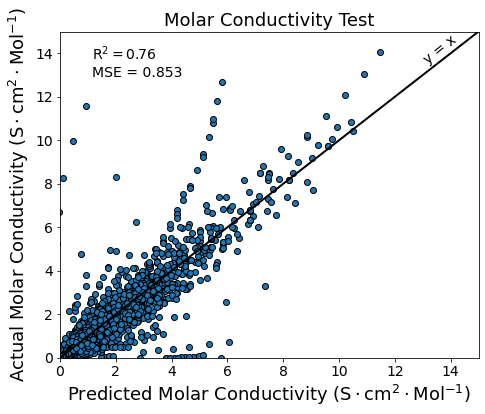

In [9]:
fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='white')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

ax1.set_xlim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))
ax1.set_ylim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))

ax1.set_xlabel('Predicted ' + Prop_name + ' ' + Units, fontsize=18)
ax1.set_ylabel('Actual ' + Prop_name + ' ' + Units, fontsize=18)

ax1.set_title(Prop_name + ' Test', fontsize=18)

plt.scatter(Final_Test_Predictions, Final_Test_Target, edgecolors='black')
plt.plot([0, np.ceil(Final_Train_Target.max())], [0, np.ceil(Final_Train_Target.max())], color = 'black', linewidth = 2)

plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(Final_Test_Target, Final_Test_Predictions),2)),(0.17,0.82), xycoords = 'figure fraction', fontsize=14)
plt.annotate('MSE = '+str(np.round(mean_squared_error(Final_Test_Target, Final_Test_Predictions),3)),(0.17,0.78), xycoords = 'figure fraction',fontsize=14)
plt.annotate('y = x ', (0.78,0.81), xycoords = 'figure fraction', rotation=38.6, fontsize=14)

plt.show()

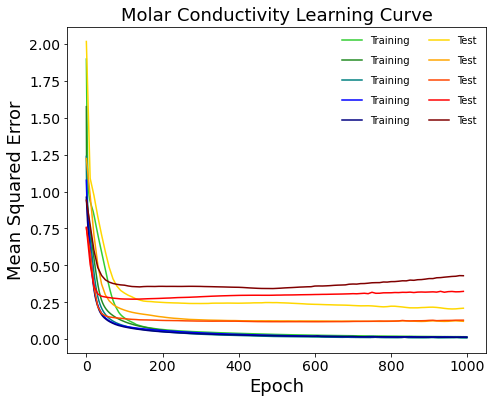

In [10]:
fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='white')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

ax1.set_title(Prop_name + ' Learning Curve', fontsize=18)

plt.plot(np.arange(0,len(Training_Losses[0]),1), Training_Losses[0], color='limegreen', label='Training')
plt.plot(np.arange(0,len(Training_Losses[1]),1), Training_Losses[1], color='forestgreen', label='Training')
plt.plot(np.arange(0,len(Training_Losses[2]),1), Training_Losses[2], color='teal', label='Training')
plt.plot(np.arange(0,len(Training_Losses[3]),1), Training_Losses[3], color='blue', label='Training')
plt.plot(np.arange(0,len(Training_Losses[4]),1), Training_Losses[4], color='navy', label='Training')

plt.plot(np.arange(0,len(Test_Losses[0])*Test_check,Test_check), Test_Losses[0], color='gold', label='Test')
plt.plot(np.arange(0,len(Test_Losses[1])*Test_check,Test_check), Test_Losses[1], color='orange', label='Test')
plt.plot(np.arange(0,len(Test_Losses[2])*Test_check,Test_check), Test_Losses[2], color='orangered', label='Test')
plt.plot(np.arange(0,len(Test_Losses[3])*Test_check,Test_check), Test_Losses[3], color='red', label='Test')
plt.plot(np.arange(0,len(Test_Losses[4])*Test_check,Test_check), Test_Losses[4], color='maroon', label='Test')

plt.legend(frameon=True, framealpha=0, fontsize=10, title_fontsize=12,  markerscale=1.75, labelspacing=1, ncol=2, columnspacing= 2)

plt.show()

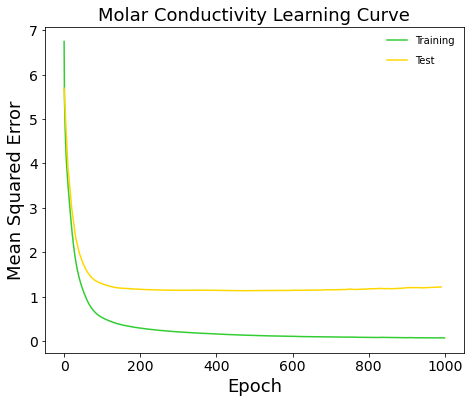

In [11]:
fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='white')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

ax1.set_title(Prop_name + ' Learning Curve', fontsize=18)

plt.plot(np.arange(0,len(Training_Losses[0]),1), Training_Losses[0]+Training_Losses[1]+Training_Losses[2]+Training_Losses[3]+Training_Losses[4], color='limegreen', label='Training')

plt.plot(np.arange(0,len(Test_Losses[0])*Test_check,Test_check), Test_Losses[0]+Test_Losses[1]+Test_Losses[2]+Test_Losses[3]+Test_Losses[4], color='gold', label='Test')

plt.legend(frameon=True, framealpha=0, fontsize=10, title_fontsize=12,  markerscale=1.75, labelspacing=1, ncol=1, columnspacing= 0)

plt.show()